In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats

import uproot

In [2]:
def add_gaussian(arr, ax):
    mu, sigma = np.mean(arr), np.std(arr)
    x = np.linspace(mu-3*sigma, mu+3*sigma, 1000)
    ax.plot(x, stats.norm.pdf(x, mu, sigma))

In [3]:
def plot_helper(ax, arrays, names, bins=100, sym_range=10.0):
    for array, name in zip(arrays, names):
        array = array[~np.isnan(array)]
        array = array[ abs(array) < sym_range ]
        _, bins, _ = ax.hist(array, bins=bins, histtype="step", label=f"{name} (mu={np.mean(array):.3f}, sigma={np.std(array):.3f})")
        #add_gaussian(pull, plt.gca())
    
    ax.legend()

In [4]:
def ec(array):
    return np.concatenate(array.array(library="np"))

In [5]:
base_dir = Path("../tmp")

In [6]:
tracksummaries = {}

for pt in ["1GeV", "10GeV", "100GeV"]:
    for fitter in ["kalman", "gsf_refit"]:
        tracksummaries[pt + "_" + fitter] = uproot.open(str(base_dir / pt / f"tracksummary_{fitter}.root") + ":tracksummary")

In [7]:
print(tracksummaries["1GeV_kalman"].keys())

['event_nr', 'track_nr', 'nStates', 'nMeasurements', 'nOutliers', 'nHoles', 'nSharedHits', 'chi2Sum', 'NDF', 'measurementChi2', 'outlierChi2', 'measurementVolume', 'measurementLayer', 'outlierVolume', 'outlierLayer', 'nMajorityHits', 'majorityParticleId', 'trackClassification', 't_charge', 't_time', 't_vx', 't_vy', 't_vz', 't_px', 't_py', 't_pz', 't_theta', 't_phi', 't_eta', 't_p', 't_pT', 't_d0', 't_z0', 'hasFittedParams', 'eLOC0_fit', 'eLOC1_fit', 'ePHI_fit', 'eTHETA_fit', 'eQOP_fit', 'eT_fit', 'err_eLOC0_fit', 'err_eLOC1_fit', 'err_ePHI_fit', 'err_eTHETA_fit', 'err_eQOP_fit', 'err_eT_fit', 'res_eLOC0_fit', 'res_eLOC1_fit', 'res_ePHI_fit', 'res_eTHETA_fit', 'res_eQOP_fit', 'res_eT_fit', 'pull_eLOC0_fit', 'pull_eLOC1_fit', 'pull_ePHI_fit', 'pull_eTHETA_fit', 'pull_eQOP_fit', 'pull_eT_fit']


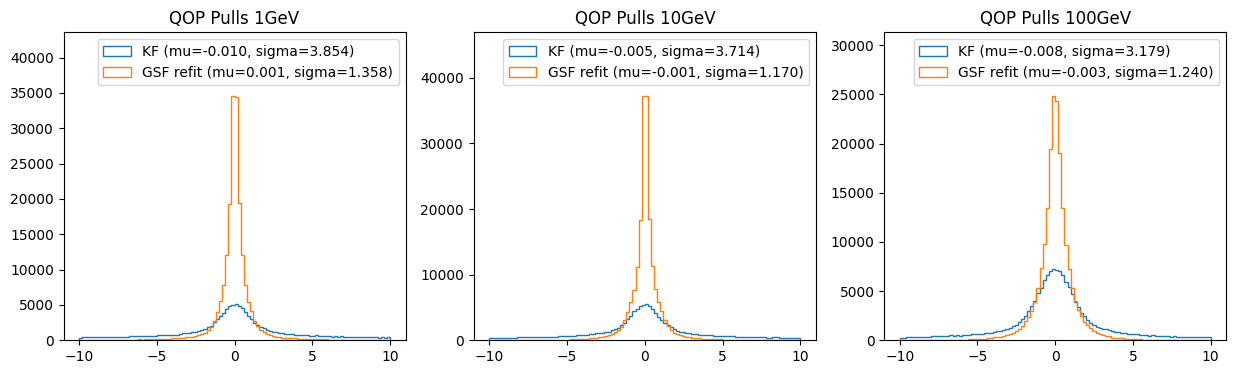

In [10]:
_, axes = plt.subplots(1,3,figsize=(15,4))

for ax, pt in zip(axes, ["1GeV", "10GeV", "100GeV"]):
    pull_kf = ec(tracksummaries[f"{pt}_kalman"]["pull_eQOP_fit"])
    pull_gsf_refit = ec(tracksummaries[f"{pt}_gsf_refit"]["pull_eQOP_fit"])
    
    plot_helper(ax, [pull_kf, pull_gsf_refit], ["KF", "GSF refit"])
    ax.set_ylim(0, ax.get_ylim()[1] * 1.2)
    ax.set_title("QOP Pulls " + pt)

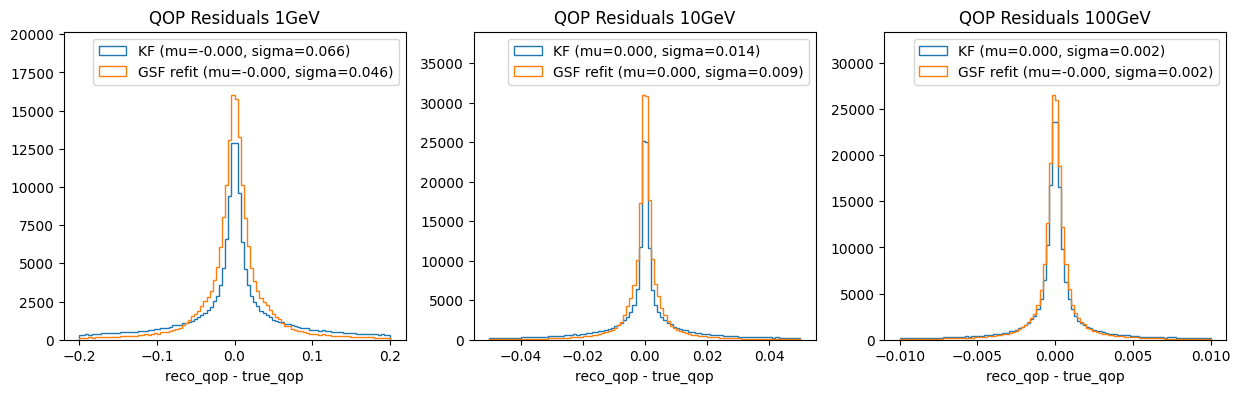

In [11]:
_, axes = plt.subplots(1,3,figsize=(15,4))

for ax, pt, sym_range in zip(axes, ["1GeV", "10GeV", "100GeV"], [0.2, 0.05, 0.01]):
    kf = ec(tracksummaries[f"{pt}_kalman"]["res_eQOP_fit"])
    gsf_refit = ec(tracksummaries[f"{pt}_gsf_refit"]["res_eQOP_fit"])
    
    plot_helper(ax, [kf, gsf_refit], ["KF", "GSF refit"], sym_range=sym_range)
    ax.set_ylim(0, ax.get_ylim()[1] * 1.2)
    ax.set_title("QOP Residuals " + pt)
    ax.set_xlabel("reco_qop - true_qop")

In [12]:
def pt_res_q_over_pt(summary):
    true_qopT = ec(summary["t_charge"])/ec(summary["t_pT"])
    reco_inv_sin_theta = 1/np.sin(ec(summary["eTHETA_fit"]))
    reco_qopT = ec(summary["eQOP_fit"]) * reco_inv_sin_theta
    return ec(summary["t_pT"]) * ( reco_qopT - true_qopT )

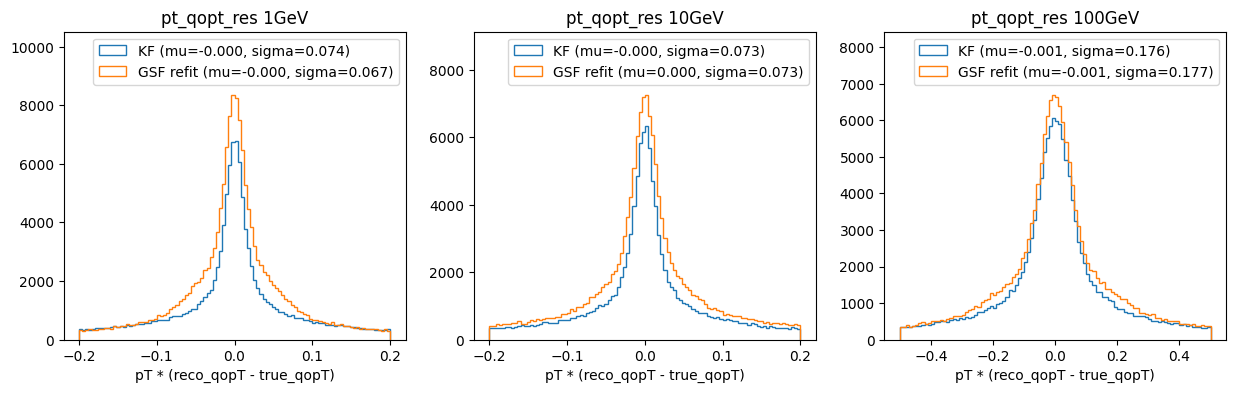

In [13]:
_, axes = plt.subplots(1,3,figsize=(15,4))

for ax, pt, sym_range in zip(axes, ["1GeV", "10GeV", "100GeV"], [0.2, 0.2, 0.5]):
    pull_kf = ec(tracksummaries[f"{pt}_kalman"]["res_eQOP_fit"])
    pull_gsf_refit = ec(tracksummaries[f"{pt}_gsf_refit"]["res_eQOP_fit"])
    
    plot_helper(ax, 
                [pt_res_q_over_pt(tracksummaries[f"{pt}_kalman"]), pt_res_q_over_pt(tracksummaries[f"{pt}_gsf_refit"])],
                ["KF", "GSF refit"], sym_range=sym_range)
    ax.set_ylim(0, ax.get_ylim()[1] * 1.2)
    ax.set_title("pt_qopt_res " + pt)
    ax.set_xlabel("pT * (reco_qopT - true_qopT)")